In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import netCDF4
import sys
import point_run_tools as prt
from itertools import combinations
import subprocess
import warnings
import sys
print(os.getcwd())
warnings.filterwarnings('ignore')

/Users/mattherworden/Downloads/CARDAMOM_2/PYTHON/Point_Run


In [2]:
#change this in order to run different cbf files
#model input file
cbffile = "CARDAMOM_DEMO_DRIVERS_prototype.cbf.nc"
CARDAMOM_loc = '../../' #change this if you move the location of CARDAMOM
cbf = netCDF4.Dataset(cbffile,'r')

## Compile CARDAMOM C files into executables (0 compile errors required to continue)

In [6]:
import subprocess
exitcode_mdf = subprocess.run(["gcc", 
                                 "-std=c99", "-lnetcdf",
                                 CARDAMOM_loc+"C/projects/CARDAMOM_MDF/CARDAMOM_MDF.c",
                                 "-o",
                                 CARDAMOM_loc+"C/projects/CARDAMOM_MDF/CARDAMOM_MDF.exe", 
                                 "-lm"], capture_output=True)

exitcode_run_dalec = subprocess.run(["gcc", 
                                   "-std=c99","-lnetcdf",
                                   CARDAMOM_loc+"C/projects/CARDAMOM_GENERAL/CARDAMOM_RUN_MODEL.c", 
                                   "-o",
                                   CARDAMOM_loc+"C/projects/CARDAMOM_GENERAL/CARDAMOM_RUN_MODEL.exe", 
                                   "-lm"], capture_output=True)

print("Total Compile errors:", exitcode_mdf.returncode+exitcode_run_dalec.returncode ,"\n\n\n")

print(" ".join(exitcode_mdf.args),"\n")
print("CARDAMOM_MDF.c compile errors:",exitcode_mdf.returncode,"\n","".join(exitcode_mdf.stderr.decode("utf-8")),"\n")
print(" ".join(exitcode_run_dalec.args),"\n")
print("CARDAMOM_RUN_MODEL.c Compile errors:",exitcode_run_dalec.returncode,"\n","".join(exitcode_run_dalec.stderr.decode("utf-8")))


Total Compile errors: 0 



gcc -std=c99 -lnetcdf ../../C/projects/CARDAMOM_MDF/CARDAMOM_MDF.c -o ../../C/projects/CARDAMOM_MDF/CARDAMOM_MDF.exe -lm 

CARDAMOM_MDF.c compile errors: 0 
  

gcc -std=c99 -lnetcdf ../../C/projects/CARDAMOM_GENERAL/CARDAMOM_RUN_MODEL.c -o ../../C/projects/CARDAMOM_GENERAL/CARDAMOM_RUN_MODEL.exe -lm 

CARDAMOM_RUN_MODEL.c Compile errors: 0 
 


## Check Model Drivers

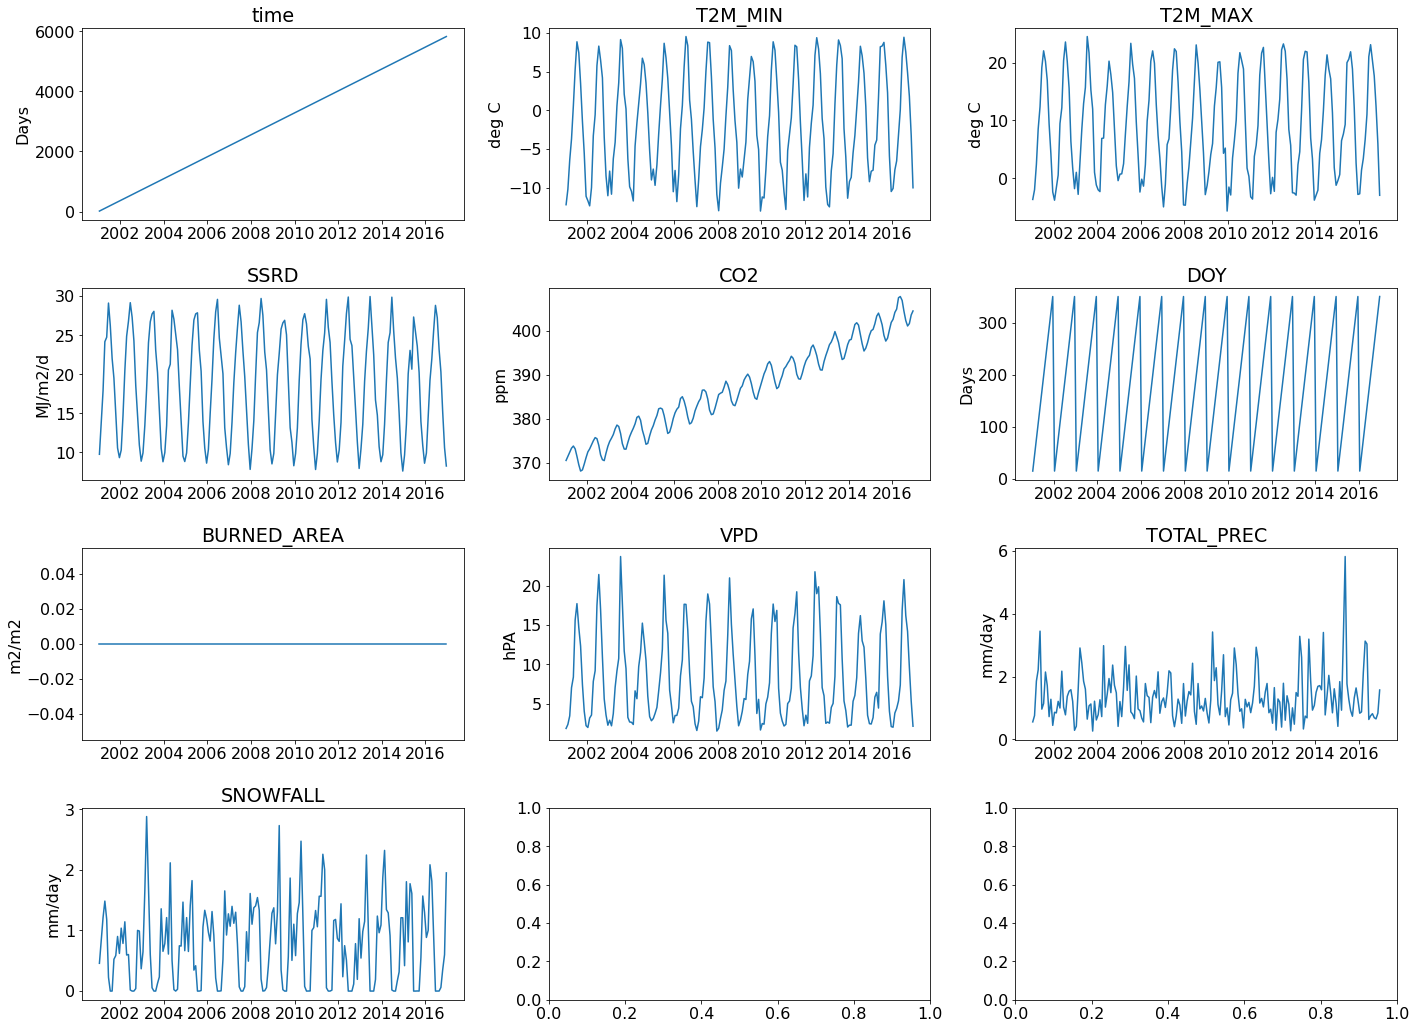

In [7]:
drivers= ['time','T2M_MIN','T2M_MAX','SSRD','CO2','DOY','BURNED_AREA','VPD','TOTAL_PREC',"SNOWFALL"]
dates = prt.get_dates(cbf['time'][:])
plt.rcParams.update({'font.size': 16})
f, axs = plt.subplots(4,3,figsize=(20,15))
f.tight_layout(pad=2.5)
for i in range(1,len(drivers)+1):
    if( drivers[i-1] in cbf.variables.keys()):
        plt.subplot(4,3,i)
        plt.title(drivers[i-1])
        plt.plot(dates,cbf[drivers[i-1]][:])
        plt.ylabel(cbf[drivers[i-1]].units)


## Run Model Data Fusion (Assimilation Runs)

In [8]:
#setup chains to be run for DEMCMC only need 1 chain for MHMCMC need 4 chains at least
chains = []
numchains = 1
for a in range(1,numchains+1):
    cmd = [CARDAMOM_loc + "C/projects/CARDAMOM_MDF/CARDAMOM_MDF.exe",cbffile,"chain_"+str(a)+".cbr" ]
    print(" ".join(cmd),"\n")
    chains+=[cmd]

../../C/projects/CARDAMOM_MDF/CARDAMOM_MDF.exe CARDAMOM_DEMO_DRIVERS_prototype.cbf.nc chain_1.cbr 



In [40]:
#Choose number of chains to run in parrallel (check how many cores/threads avaiable on computer)
import os
max_processes = 4
if max_processes > numchains:
    max_processes = numchains
    print("Don't waste computation!")

processes = set()
for name in chains:
    a = processes.add(subprocess.Popen(name))
    if len(processes) >= max_processes:
        os.wait()
        processes.difference_update([p for p in processes if p.poll() is not None])
print("assimilation complete")        

Don't waste computation!
assimilation complete


## Check posterior paramater distributions (CBR files) for convergence

Within-walker convergence: the distribution of parameter values within the first and second half of samples for a given walker (exclude burn in)

Across-walker convergence: the distribution of parameter values across all 200 walkers (exclude burn in)

Across Walker Convergence % GR < 1.2: 89.855%
Across Walker Mean GR Convergence : 1.073


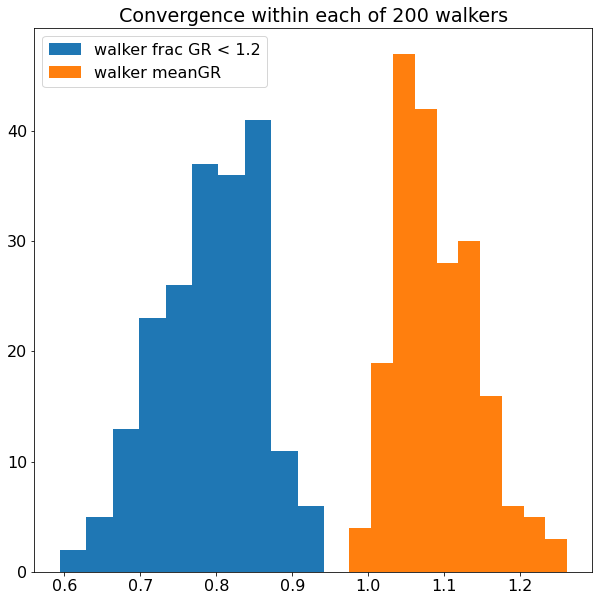

In [9]:
L = [f for f in os.listdir() if f.endswith('.cbr')]

numpars = prt.numpars(CARDAMOM_loc,int(cbf["ID"][:]))
fracs,meangrs,Across_walkersgr  =  prt.DEMCMC_conv(L,numpars)
    
plt.rcParams.update({'font.size': 16})    
plt.figure(figsize = (10,10))
plt.title("Convergence within each of 200 walkers")
plt.hist(fracs,label = 'walker frac GR < 1.2')
plt.hist(meangrs,label = 'walker meanGR')
plt.legend()

acfracgr = len(Across_walkersgr[Across_walkersgr<1.2])/len(Across_walkersgr)
acmeangr = np.mean(Across_walkersgr)
print("Across Walker Convergence % GR < 1.2: " + str(round(acfracgr*100,3)) + "%")
print("Across Walker Mean GR Convergence : " + str(round(acmeangr,3)))
plt.show()

# Plot posterior paramater distribution

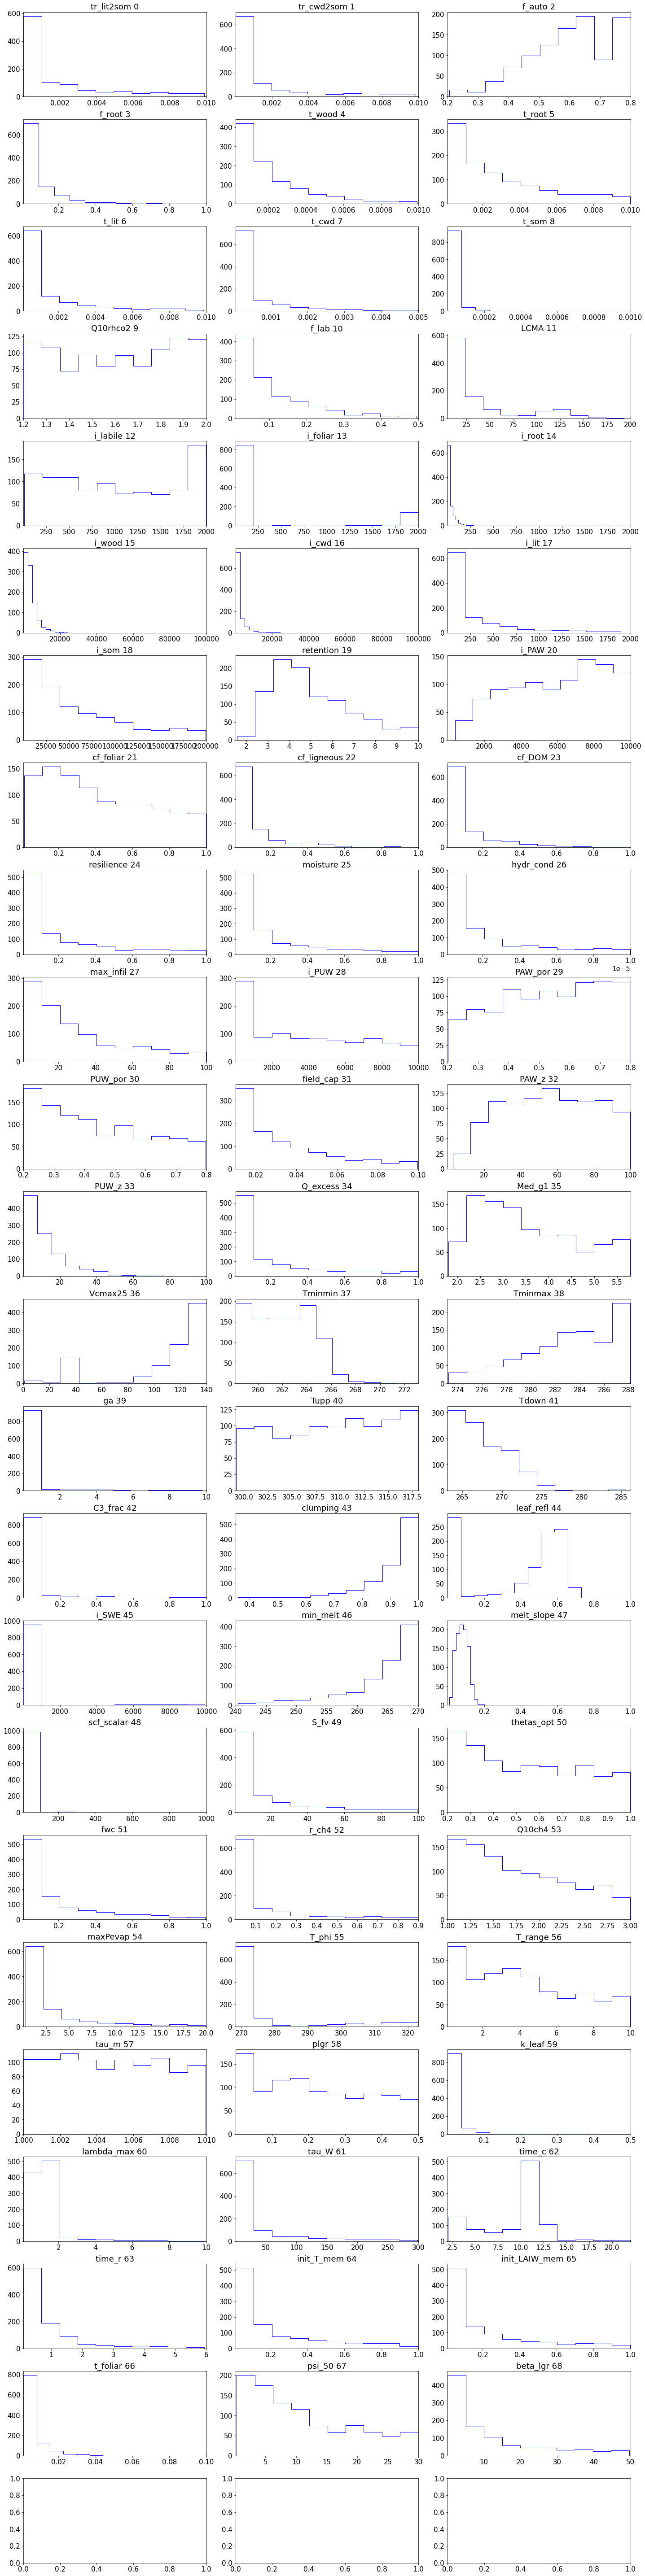

In [10]:
parinfo = prt.cbr_info(CARDAMOM_loc, int(cbf["ID"][:]))
cbrfile = L[0]
cbr = prt.read_cbr_file(cbrfile,numpars)

plt.rcParams.update({'font.size': 15})
f, axs = plt.subplots(int(numpars/3)+1,3,figsize=(20,80))
f.tight_layout(pad=1.5)
for i,a in enumerate(parinfo.keys()):
    plt.subplot(int(numpars/3)+1,3,i+1)
    plt.title(a + " " + str(i))
    plt.hist(cbr[:,parinfo[a][0]],color = 'blue',histtype=u'step')
    plt.xlim(parinfo[a][1],parinfo[a][2])#This line set the x axis to the prior distributino range remove for closer detail on distribution
 


## Run DALEC with posterior paramater distributions 

In [11]:
exitcode_DALEC_run = subprocess.run([CARDAMOM_loc+"C/projects/CARDAMOM_GENERAL/CARDAMOM_RUN_MODEL.exe", 
                              cbffile,
                              cbrfile] , capture_output=True)

print(" ".join(exitcode_DALEC_run.args),"\n")
print("run errors:",exitcode_DALEC_run.returncode,"\n","".join(exitcode_DALEC_run.stderr.decode("utf-8")))



../../C/projects/CARDAMOM_GENERAL/CARDAMOM_RUN_MODEL.exe CARDAMOM_DEMO_DRIVERS_prototype.cbf.nc chain_1.cbr 

run errors: 0 
 


## Plot DALEC Fluxes from optimal parmaters

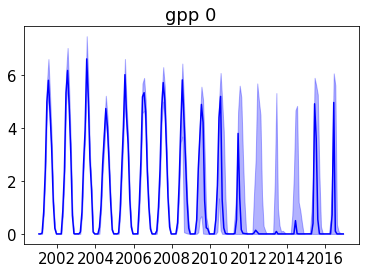

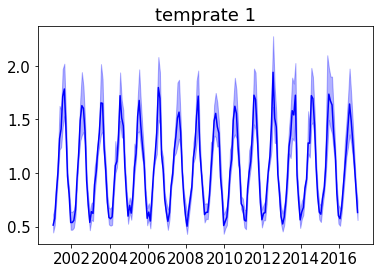

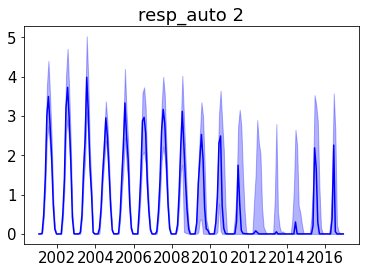

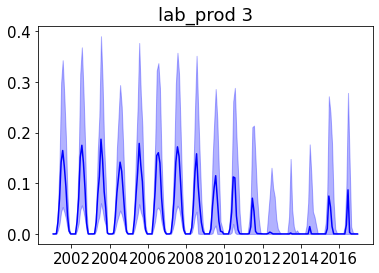

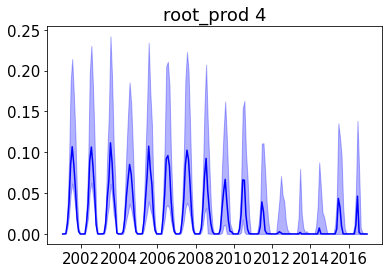

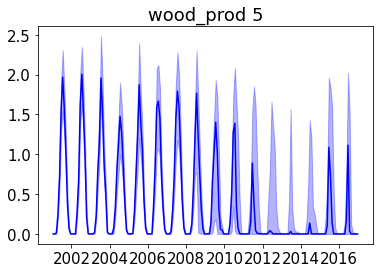

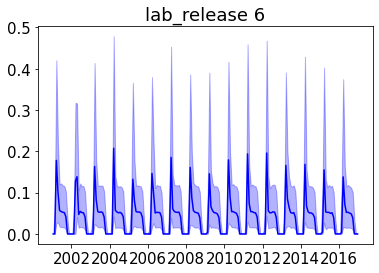

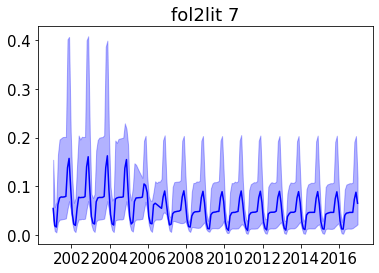

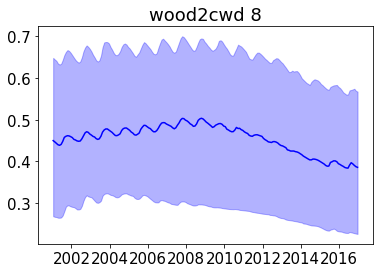

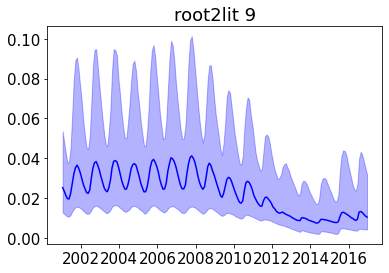

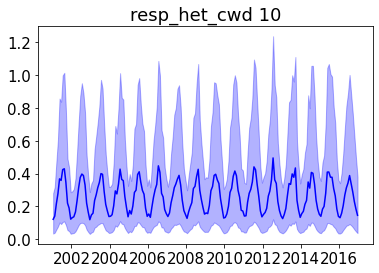

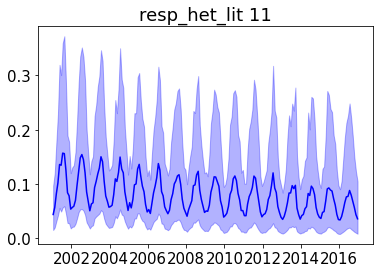

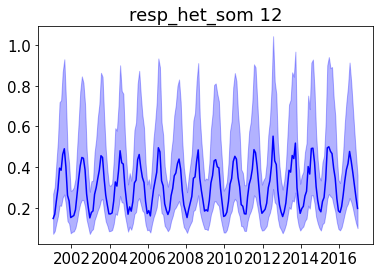

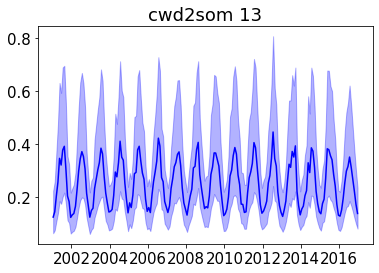

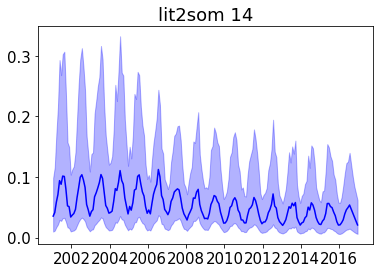

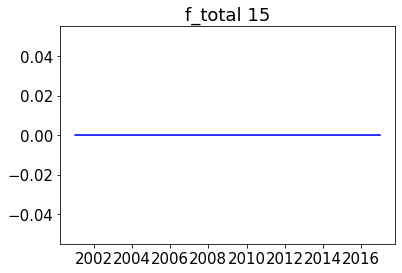

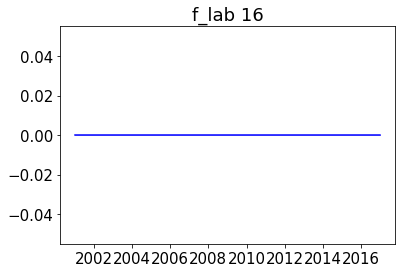

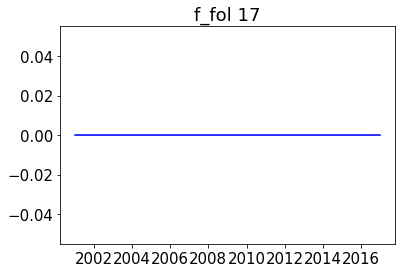

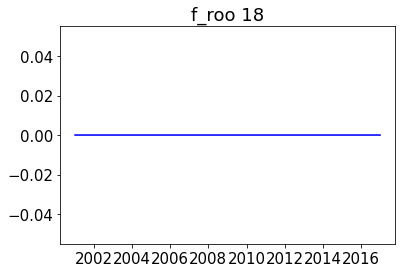

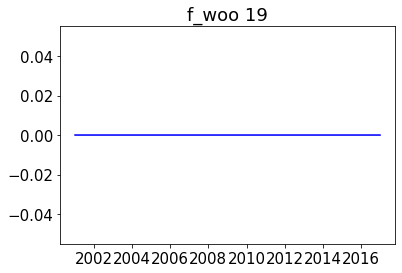

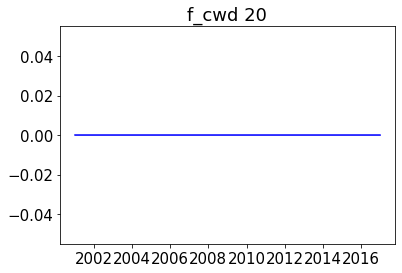

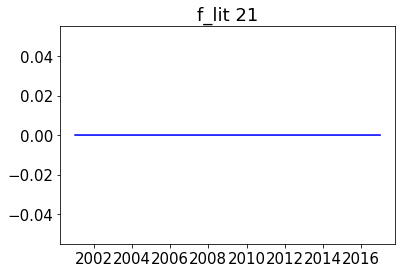

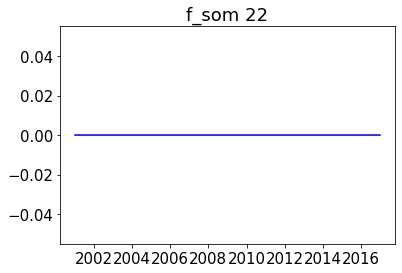

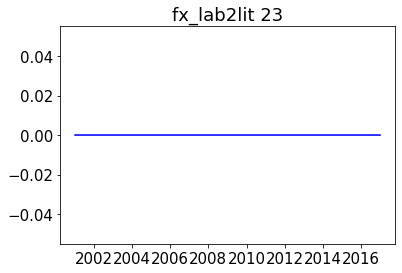

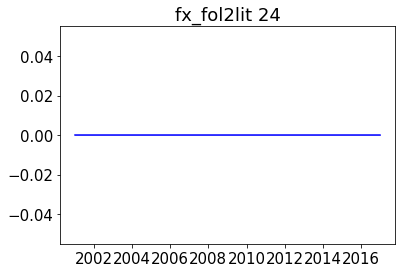

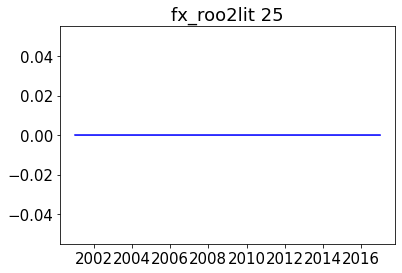

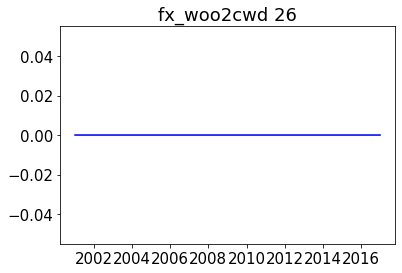

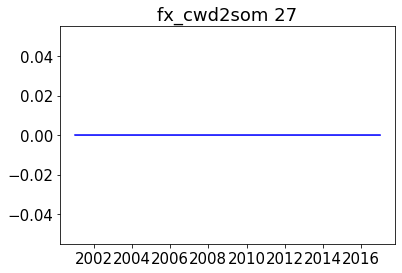

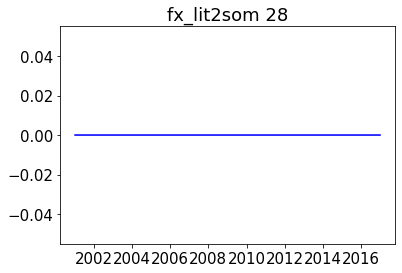

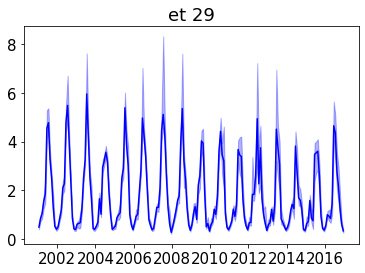

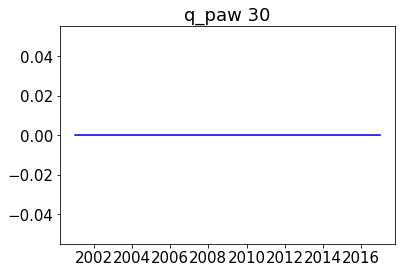

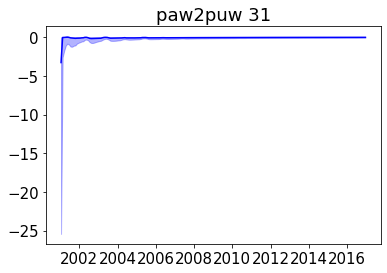

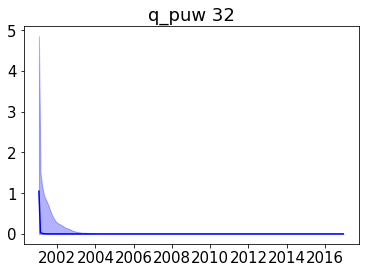

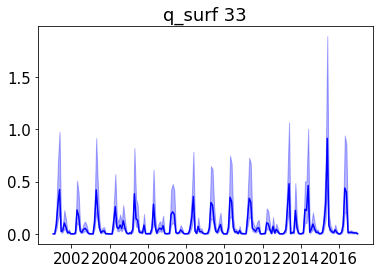

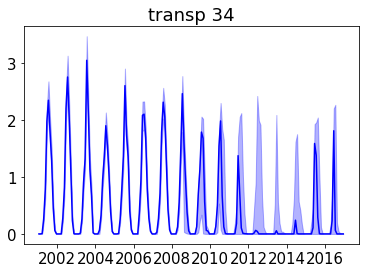

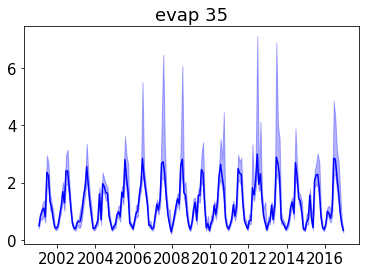

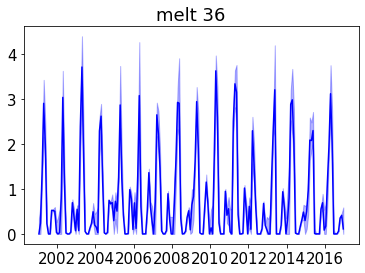

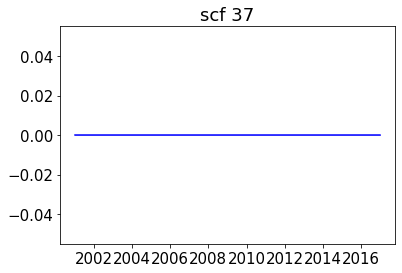

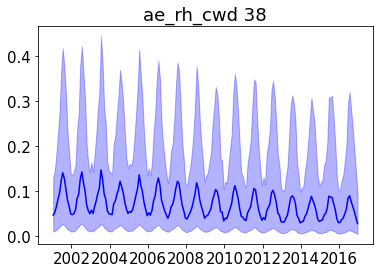

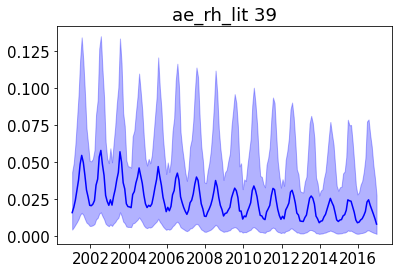

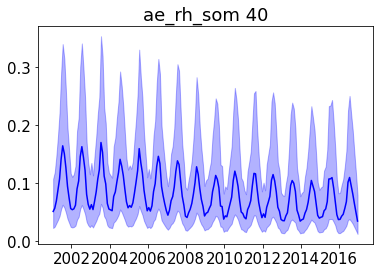

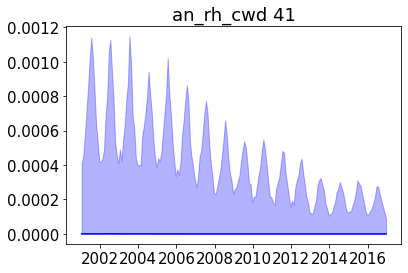

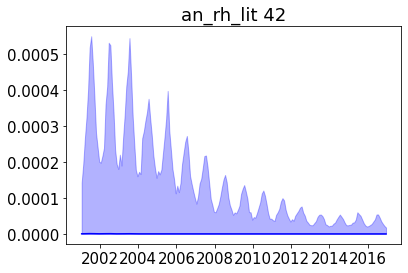

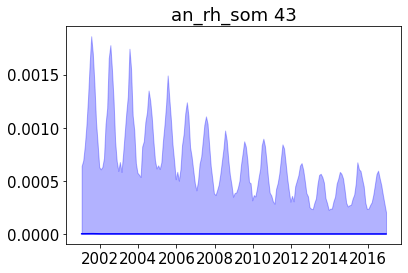

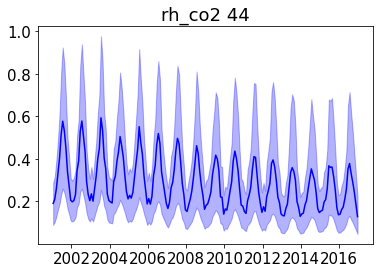

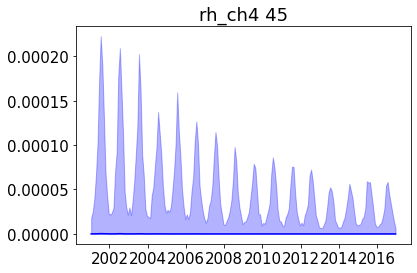

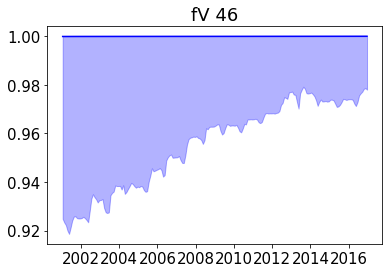

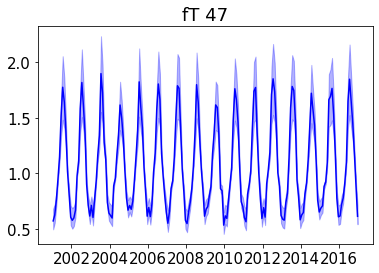

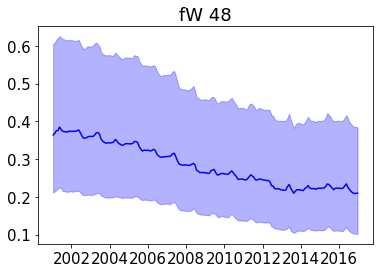

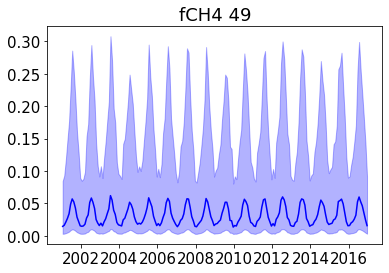

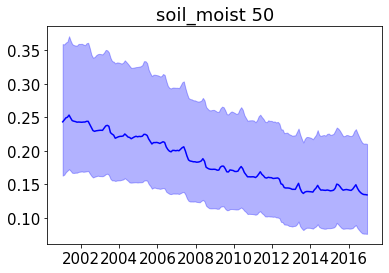

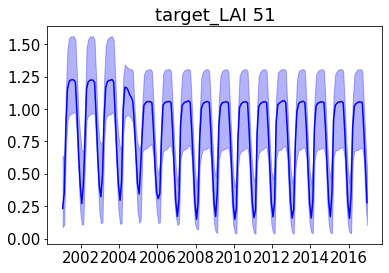

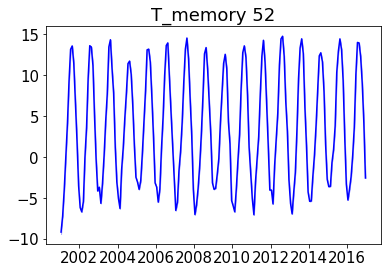

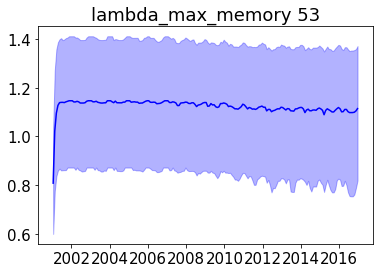

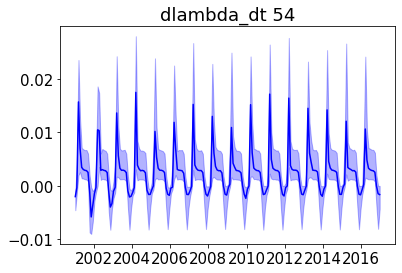

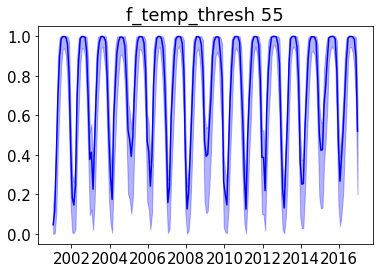

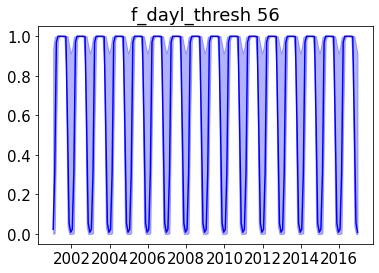

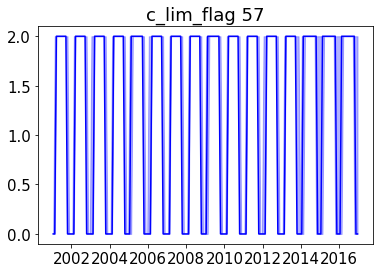

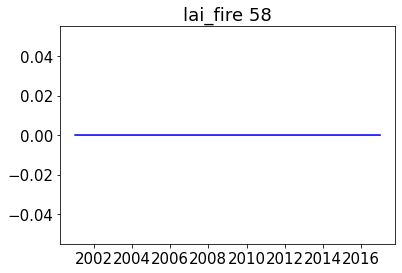

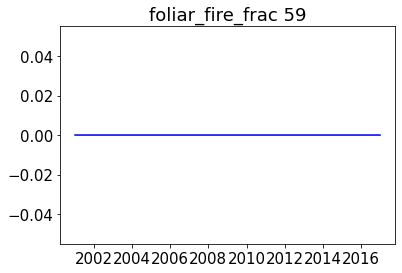

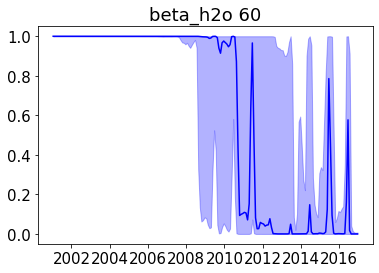

In [12]:
Fluxes = np.array(netCDF4.Dataset(cbrfile+'.nc')['FLUXES'])
Fluxes_noburn = Fluxes[int(Fluxes.shape[0]/2):,:,:]
fluxinfo = prt.flux_info(CARDAMOM_loc,int(cbf["ID"][:]))

for a in fluxinfo.keys():
    plt.figure()
    plt.title(fluxinfo[a] + " " + str(a))
    plt.plot(dates,np.median(Fluxes_noburn[:,:,a],axis = 0),color = 'blue')
    SDist = np.percentile(Fluxes_noburn[:,:,a],[25,75],axis = 0)
    plt.fill_between(dates, SDist[0,:], SDist[-1,:], color="blue", alpha=.3)

plt.show()


## Plot DAELC Pools from optimal paramaters

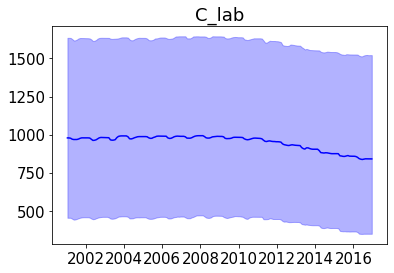

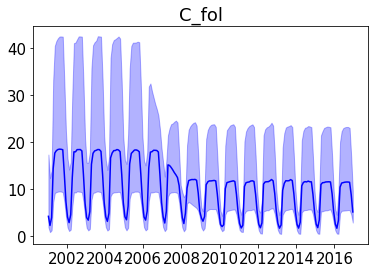

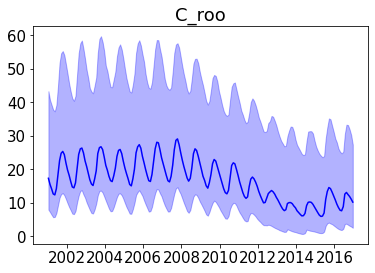

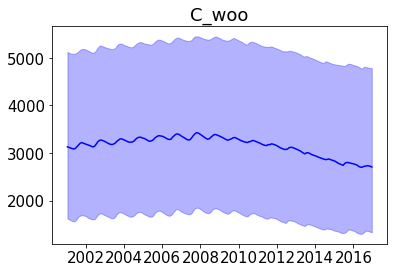

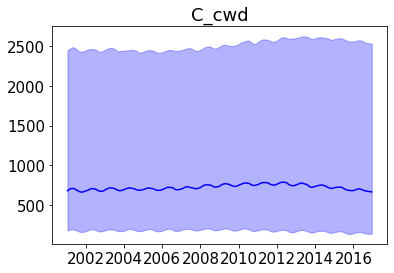

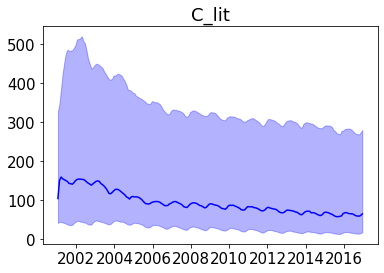

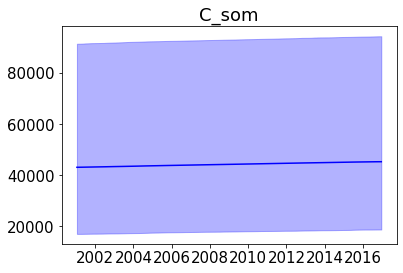

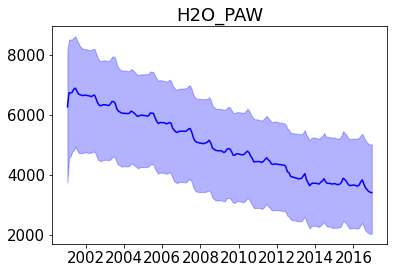

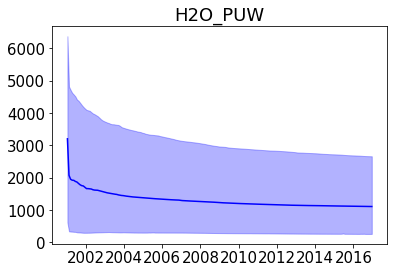

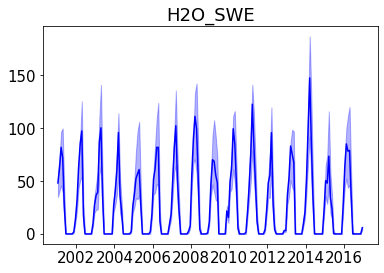

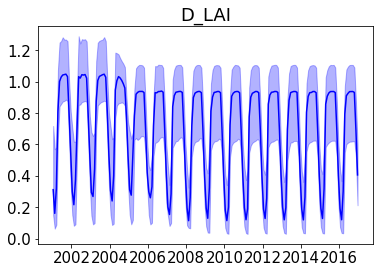

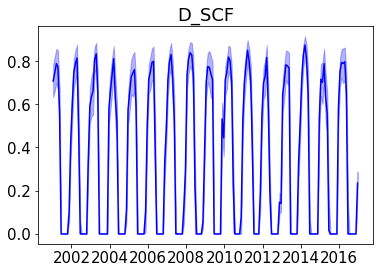

In [13]:
Pools = np.array(netCDF4.Dataset(cbrfile+'.nc')['POOLS'])
Pools_noburn = Pools[int(Fluxes.shape[0]/2):,:,:]
poolinfo = prt.pool_info(CARDAMOM_loc,int(cbf["ID"][:]))

for a in poolinfo.keys():
    plt.figure()
    plt.title(poolinfo[a])
    plt.plot(dates,np.median(Pools_noburn[:,:,a],axis = 0)[0:-1],color = 'blue')
    SDist = np.percentile(Pools_noburn[:,:,a],[25,75],axis = 0)
    plt.fill_between(dates, SDist[0,0:-1], SDist[-1,0:-1], color="blue", alpha=.3)

plt.show()

In [14]:
cbf.close() #close the cbf file